In [22]:
import requests
import pandas as pd
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Load the main dataset
train_df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/train.csv')  # Replace with your file path
historical_data_df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/historical_data.csv')  # Replace with your file path

train_df['Order_Date'] = pd.to_datetime(train_df['Order_Date'], format='%d-%m-%Y', errors='coerce')
train_df['Time_Orderd'] = pd.to_datetime(train_df['Time_Orderd'], format='%H:%M:%S', errors='coerce')

# Feature engineering and preparation
train_df['Time_taken(min)'] = train_df['Time_taken(min)'].str.extract('(\d+)').astype(float)
train_df['Distance_km'] = train_df.apply(
    lambda row: geodesic(
        (row['Restaurant_latitude'], row['Restaurant_longitude']),
        (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
    ).kilometers, axis=1
)

train_df['Rush_Hour'] = train_df['Time_Orderd'].apply(
    lambda x: 1 if x and (7 <= x.hour <= 9 or 17 <= x.hour <= 19) else 0
)
train_df['Day_of_Week'] = train_df['Order_Date'].dt.day_name()
train_df['Time_of_Day'] = train_df['Time_Orderd'].apply(
    lambda x: 'Morning' if 6 <= x.hour < 12 else 
              ('Afternoon' if 12 <= x.hour < 17 else 
               ('Evening' if 17 <= x.hour < 21 else 'Night')) if pd.notnull(x) else 'Unknown'
)

train_df = pd.get_dummies(train_df, columns=['Day_of_Week', 'Time_of_Day'], drop_first=True)

historical_data_df['created_at'] = pd.to_datetime(historical_data_df['created_at'], errors='coerce')
historical_data_df['created_at_date'] = historical_data_df['created_at'].dt.date
train_df['Order_Date_Date'] = train_df['Order_Date'].dt.date

train_df = pd.merge(
    train_df,
    historical_data_df[['created_at_date', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']],
    how='left',
    left_on='Order_Date_Date',
    right_on='created_at_date'
)

train_df.drop(columns=['Order_Date_Date', 'created_at_date'], inplace=True)

# Define features and target
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_km', 'Vehicle_condition', 'Rush_Hour',
            'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'] + \
           [col for col in train_df.columns if 'Day_of_Week_' in col or 'Time_of_Day_' in col]

X = train_df[features].fillna(0)
y = train_df['Time_taken(min)']

# Impute, scale, and split the data
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("Final R^2 Score:", r2_xgb)

Final R^2 Score: 0.5113890561678031


In [23]:
from sklearn.model_selection import cross_val_score

cross_val_r2 = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", cross_val_r2)
print("Mean R^2 score:", np.mean(cross_val_r2))




Cross-validated R^2 scores: [0.5242224  0.5197462  0.50542312 0.50421658 0.50081895]
Mean R^2 score: 0.5108854504911863


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


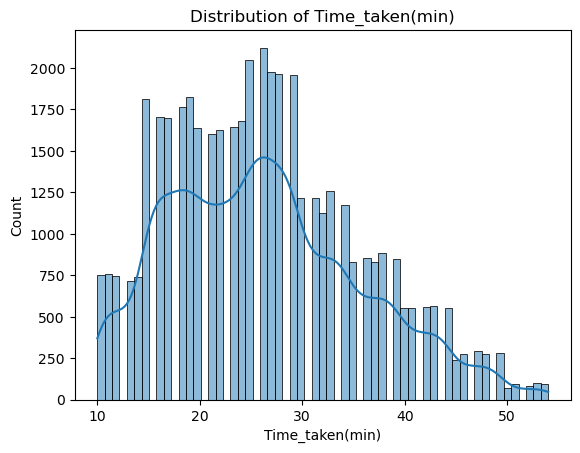

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train_df['Time_taken(min)'], kde=True)
plt.title("Distribution of Time_taken(min)")
plt.show()


In [16]:
non_numeric_columns = train_df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Time_Order_picked', 'Weatherconditions',
       'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City'],
      dtype='object')


In [17]:
for col in non_numeric_columns:
    print(f"Unique values in {col}:", train_df[col].unique())


Unique values in ID: ['0x4607 ' '0xb379 ' '0x5d6d ' ... '0x4f8d ' '0x5eee ' '0x5fb2 ']
Unique values in Delivery_person_ID: ['INDORES13DEL02 ' 'BANGRES18DEL02 ' 'BANGRES19DEL01 ' ...
 'KOCRES04DEL01 ' 'BHPRES06DEL03 ' 'GOARES03DEL03 ']
Unique values in Delivery_person_Age: ['37' '34' '23' '38' '32' '22' '33' '35' '36' '21' '24' '29' '25' '31'
 '27' '26' '20' 'NaN ' '28' '39' '30' '15' '50']
Unique values in Delivery_person_Ratings: ['4.9' '4.5' '4.4' '4.7' '4.6' '4.8' '4.2' '4.3' '4' '4.1' '5' '3.5'
 'NaN ' '3.8' '3.9' '3.7' '2.6' '2.5' '3.6' '3.1' '2.7' '1' '3.2' '3.3'
 '6' '3.4' '2.8' '2.9' '3']
Unique values in Time_Order_picked: ['11:45:00' '19:50:00' '08:45:00' '18:10:00' '13:45:00' '21:30:00'
 '19:30:00' '17:30:00' '21:05:00' '22:10:00' '15:05:00' '17:40:00'
 '09:30:00' '20:05:00' '20:35:00' '15:10:00' '20:40:00' '20:50:00'
 '20:25:00' '22:45:00' '08:30:00' '19:45:00' '12:30:00' '18:50:00'
 '23:30:00' '21:35:00' '23:45:00' '22:50:00' '22:40:00' '23:35:00'
 '13:40:00' '21:45:00' '

In [18]:
train_df['column_name'] = pd.to_numeric(train_df['column_name'], errors='coerce')


KeyError: 'column_name'

In [19]:
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


ValueError: could not convert string to float: '0x4607 '

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42
)

xgb_random.fit(X_train, y_train)
best_model = xgb_random.best_estimator_
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print("Tuned R^2 Score:", r2_best)


Tuned R^2 Score: 0.506942859226803


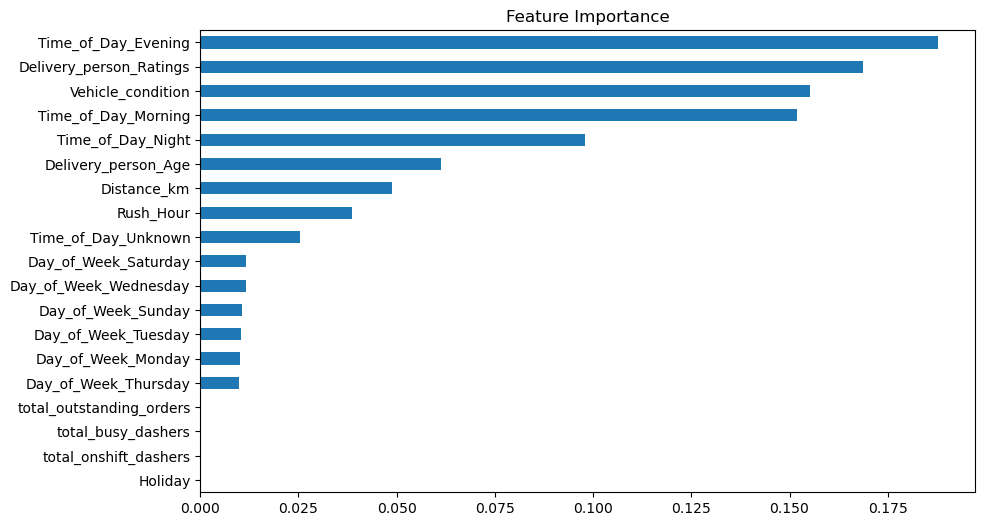

In [6]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(xgb_model.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()


In [7]:
features_without_holiday = [feat for feat in features if feat != 'Holiday']
X_without_holiday = train_df[features_without_holiday].fillna(0)

# Redo the preprocessing steps
X_imputed = imputer.fit_transform(X_without_holiday)
X_scaled = scaler.fit_transform(X_imputed)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train and evaluate
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb_without_holiday = r2_score(y_test, y_pred_xgb)
print("R^2 Score without Holiday Feature:", r2_xgb_without_holiday)


R^2 Score without Holiday Feature: 0.49597080908723257


In [21]:
selected_features = ['Distance_km', 'Rush_Hour', 'Delivery_person_Age', 'Delivery_person_Ratings']
X_selected = train_df[selected_features].fillna(0)

X_imputed = imputer.fit_transform(X_selected)
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_selected = xgb_model.predict(X_test)
r2_selected = r2_score(y_test, y_pred_selected)
print("R^2 Score with selected features:", r2_selected)


R^2 Score with selected features: 0.3799482359976507
